# Classification with Deep Neural Networks

실제 서비스나 배포를 염두에 두고 있는 머신러닝 프로젝트를 수행중이라면, 모델을 배포하기에 앞서 면밀하게 모델의 성능을 검토하는 작업을 수행해야 합니다. 이번 장에는 다중 클래스 분류multi class classification의 결과 분석을 위한 방법인 혼동 행렬confusion matrix에 대해서 소개하도록 하겠습니다.

## Load MNIST Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms
from IPython.display import Image

min-max 정규화
최소값을 0, 최대값을 1로 하여 범위를 0~1로 변환하는 방법


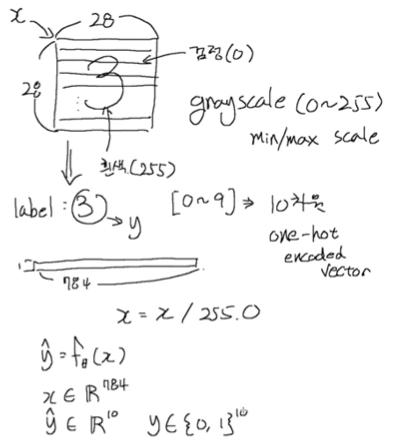

In [3]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\30.png")

28 X 28 차원을 28개로 잘라서 쭉 하나로 이어붙임
그럼 1 X 784 차원이 됨. y_hat은 ((10,) = 벡터)
0부터 9차원이 있으니깐 
y는 '3'이라는 값 하나가 들어잇는 longtensor니깐 {0,1} 10차원의 one-hot encoded vector가 됨.


In [3]:
# train set과 test set으로 나눔
train = datasets.MNIST(
    '../data', train=True, download=True, #Train = True,(Train set인지 True/False),
                                            # 사진이 data에 없을경우 download = True(다운로드를 한다)
    
    transform=transforms.Compose([ #transforms.Compose - 여러 단계로 변환해야 하는 경우, Compose를 통해 여러 단계를 묶을 수 있다
        transforms.ToTensor(), #transforms.ToTensor() - 데이터를 tensor로 바꿔준다.
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



데이터 샘플을 시각화할 수 있는 함수를 미리 하나 만들어보려합니다. 지금이야 MNIST라는 유명한 데이터셋을 다루기 때문에 딱히 데이터에 대한 분석 없이 넘어가지만, 만약 처음보는 데이터셋이라면 다양한 시각화를 통해 데이터셋에 대한 특성을 먼저 파악해야 할 것입니다.

In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

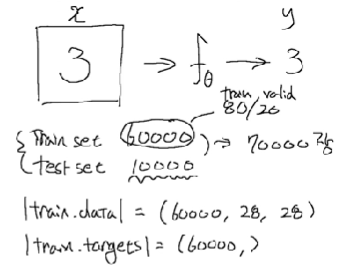

In [5]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\31.png")

train.data = (60000,28,28)
train.targets = (60000,) #벡터로 들어있다. 원학벡터의 인덱스만 들어있으면됨. 그럼 우리는 원핫벡터를 가지고있는거랑 똑같음


앞서 만든 plot 함수에 학습 데이터셋의 첫 번째 샘플을 집어넣어보겠습니다

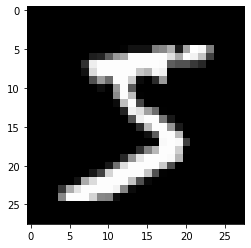

In [5]:
plot(train.data[0])

MNIST 샘플의 각 픽셀은 0에서부터 255까지의 숫자로 이루어진 그레이스케일gray scale로 구성되어 있습니다. 따라서 255로 각 픽셀 값을 나눠주면, 0에서 1까지의 값으로 정규화normalization할 수 있습니다. 그리고 현재 우리의 신경망은 선형 계층으로만 이루어질 것이기 때문에, 2D 이미지도 1차원 벡터로 flatten하여 나타내야 합니다. 하나의 샘플은  
28
×
28
  크기의 픽셀들로 이루어져 있습니다.[3] 따라서 이 2차원 행렬을 1차원 벡터로 flatten할 경우, 784 크기의 벡터가 될 것입니다.

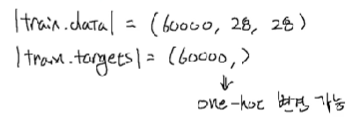

In [3]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\2.png")

In [6]:
x = train.data.float() / 255. #MinMax scaling 
y = train.targets

x = x.view(x.size(0), -1)
# x라는 텐서를 (60000, ?)의 크기로 변경
print(x.shape, y.shape) # y값에는 60000차원의 longtensor가 들어있음. longtensor가 들어있음 자연스럽게 onehot으로 변경가능

input_size = x.size(-1) #그래서 input 사이즈는 784. x.size(-1)=784
output_size = int(max(y)) + 1 #y값은 10차원. y중에서 가장 큰값 =9 + 1 = 10개. 

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [13]:
x = train.data.float() / 255
x.size() #원래 3차원인데 .view(x.size(0),-1)통해서 한차원 줄임

torch.Size([60000, 28, 28])

In [15]:
x = x.view(x.size(0),-1)
x.size()

torch.Size([60000, 784])

In [7]:
#test set은 10000으로 고정하지만 train set 60000장을 train과 valid 비율인 8대2로 나눈다.

# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)] #min/max scale을 하고  flatten해주는 .view()써서 784차원의 샘플을 벡터로 변환한다.
y += [test.targets]

#y는 longtensor로 one-hot 벡터가 들어있는게 아니라 원핫벡터 인덱스가 들어있다.

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


MinMax Scale

다르게 주어진 피처의 변수를 모두 동일한 크기 단위로 비교하기 위해 값은 모두 최솟값을 0, 최댓값을 1로


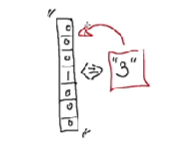

In [3]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\22.png")

y는 longtensor로 one-hot 벡터가 들어있는게 아니라 원핫벡터 인덱스(3)가 들어있다. 둘은 상호변환가능하다

## Build Model & Optimizer

In [8]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

model

# 이 네트워크는 이미지를 벡터로 flatten한걸 받아서 각 클래스별 log확률값을 return하는 모델이 되는거임

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

y_hat 에 각 클래스별 log확률값이 들어있음
그래서 클래스가 0에서 9까지 10개가 들어있어서 10차원의 벡터가 나와야한다. 그래서 맨 마지막을 10차원으로 빼주고 확률값을 표현할꺼니깐 logsoftmax을 y_hat의 두번째 dimension에 대해서 써주는게 좋음. 이렇게 neural network를 만듦.

그래서 이 네트워크는 이미지를 벡터로 flatten한걸 받아서 각 클래스별 log확률값을 return하는 모델이 되는거임


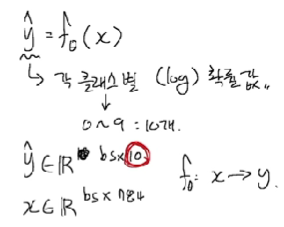

In [4]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\3.png")

0~9까지 10개의 각 클래스별 확률값을 줘야하니깐 10차원의 벡터가 나와야한다. 그래서 y_hat은 10차원이다. 그래서 맨마지막을 10차원으로 빼준다.그리고 Y-hat의 두번째 차원에 logsoftmax해야하니깐 (dim= -1)한다.

In [9]:
crit = nn.NLLLoss() #logsoftmax를 썼으니깐 NLL을 쓴다. 

In [10]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

애는 어느정도 스케일이 있다보니깐 GPU 쓰는게 좋다.

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') #cuda가 활용가능할경우에는 cuda로 가자

In [12]:
model = model.to(device) #(device)가 cuda로 되어있으면 gpu로 보낸다

x = [x_i.to(device) for x_i in x] #마찬가지로 train,valid,test도 gpu로 보낸다
y = [y_i.to(device) for y_i in y]

## Train

In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [14]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [15]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.2119e-02  valid_loss=1.1302e-01  lowest_loss=9.5662e-02
Epoch 20: train loss=1.1494e-02  valid_loss=1.1124e-01  lowest_loss=9.5662e-02
Epoch 30: train loss=7.9660e-03  valid_loss=1.1719e-01  lowest_loss=9.5662e-02
Epoch 40: train loss=4.3731e-03  valid_loss=1.2816e-01  lowest_loss=9.5662e-02
Epoch 50: train loss=4.4661e-03  valid_loss=1.3524e-01  lowest_loss=9.5662e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 8: 9.5662e-02


<All keys matched successfully>

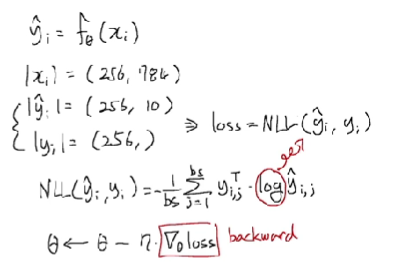

In [4]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\1111.png")

## Loss History

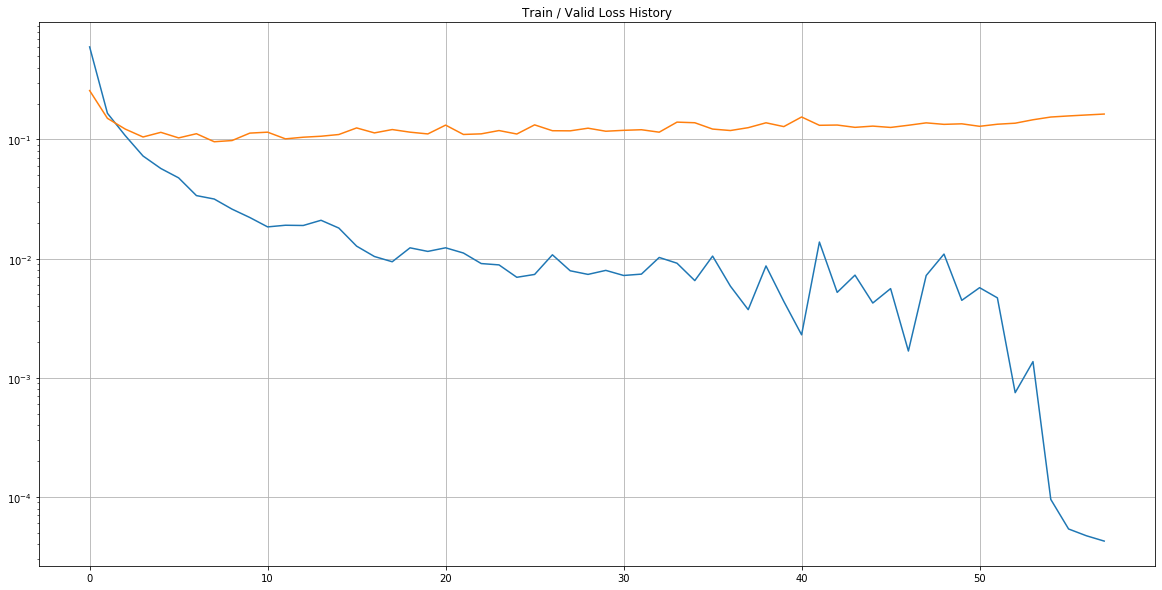

In [16]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

주황색이 validatin loss, 파란색이 train loss

## Let's see the result!

In [17]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 8.9894e-02


In [18]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9757


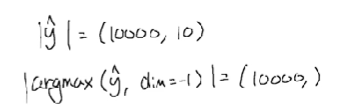

In [5]:
Image("C:\\Users\\ryusu\\OneDrive\\바탕 화면\\333.png")


y_hat = (10000,1) y_hat은 10000차원의 벡터
y_hat의 마지막차원에 argmax를 하면 (10000,) 즉 10000차원의 벡터가 나올것이다. 콤마뒤 공백은 해당인덱스가 들어가고 1이 들어가서 안쓴거 
그래서 y[-1].squeeze() == torch.argmax(y_hat, dim = -1)이 같은지 틀린지 보고 같으면 1, 틀리면 0이고 이것의 sum을 하면은 correct_count 가 나온다. 
0.9757 은 9757개 맞고 243개 틀림


Confusion Matrix도 그려본다

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [20]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,0,0,1,0,1,3,0,3,1
true_1,0,1123,2,2,1,1,1,0,5,0
true_2,11,1,980,6,2,0,3,10,18,1
true_3,0,0,2,986,0,3,0,6,3,10
true_4,1,0,1,0,967,0,5,1,1,6
true_5,1,0,0,15,0,866,2,1,3,4
true_6,2,3,0,0,2,4,942,0,5,0
true_7,2,2,6,0,0,0,0,996,3,19
true_8,4,0,1,3,2,7,0,3,949,5
true_9,3,2,0,2,18,1,0,3,3,977


정답(y[-1])과 예측에 대한 인덱스(torch.argmax(y_hat, dim = -1))을 넣어서 confusion matrix를 구하면 numpy.array를 return 해주는데 그것을 dataframe 에 넣어준다. 
